In [8]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import os
import cv2

In [9]:
# Config
subject_number = 118
view = "side"
input_file = f"./input/mediapipe/{subject_number}/{subject_number}_{view}_landmarks.json"
video_file = f"./input/mediapipe/{subject_number}/{subject_number}_{view}_pose.mp4"
outputdir = f"./output/{subject_number}"
output_file = f"./output/{subject_number}/{subject_number}_{view}_2_gait_cycles.json"
screenshots_dir = f"./output/{subject_number}/{view}_heel_strike_screenshots"

fps = 30.0

landmarks = {
    0: "Nose", 1: "Left_Eye_Inner", 2: "Left_Eye", 3: "Left_Eye_Outer",
    4: "Right_Eye_Inner", 5: "Right_Eye", 6: "Right_Eye_Outer",
    7: "Left_Ear", 8: "Right_Ear", 9: "Mouth_Left", 10: "Mouth_Right",
    11: "Left_Shoulder", 12: "Right_Shoulder", 13: "Left_Elbow", 14: "Right_Elbow",
    15: "Left_Wrist", 16: "Right_Wrist", 17: "Left_Pinky", 18: "Right_Pinky",
    19: "Left_Index", 20: "Right_Index", 21: "Left_Thumb", 22: "Right_Thumb",
    23: "Left_Hip", 24: "Right_Hip", 25: "Left_Knee", 26: "Right_Knee",
    27: "Left_Ankle", 28: "Right_Ankle", 29: "Left_Heel", 30: "Right_Heel",
    31: "Left_Foot_Index", 32: "Right_Foot_Index"
}

landmark_index = 30
landmark_name = landmarks[landmark_index]

os.makedirs(outputdir, exist_ok=True)
os.makedirs(screenshots_dir, exist_ok=True)

#Clear old screenshots from screenshots dir
for f in os.listdir(screenshots_dir):
    path = os.path.join(screenshots_dir, f)
    if os.path.isfile(path):
        os.remove(path)

In [10]:
# Load and rewrite files to exclude none and null values
with open(input_file, "r") as f:
  data = json.load(f)

data['landmarks_data'] = [frame for frame in data['landmarks_data'] if (frame['pose_landmarks'] is not None)]

with open(input_file, 'w') as outfile:
  json.dump(data, outfile, indent=4)

In [11]:
# Load mediapipe data
with open(input_file, "r") as f:
    data = json.load(f)   
    
frames = data["landmarks_data"]
points = []
for frame in frames:
    if "pose_landmarks" in frame and frame["pose_landmarks"]:
        arr = np.array(frame["pose_landmarks"])[:, :3]
        points.append(arr)
    else:
        points.append(None)

In [12]:
def smooth_pose_butter(poses, cutoff=3, fs=30, order=4):
    """
    cutoff: cutoff frequency (Hz)
    fs: sample rate (frames per second)
    order: filter order
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    smoothed = np.copy(poses)
    for j in range(poses.shape[1]):
        for k in range(3):
            smoothed[:, j, k] = filtfilt(b, a, poses[:, j, k])
    return smoothed

In [13]:
points = np.array(points)
points = smooth_pose_butter(points, fs=fps, order=4)

In [14]:
# Compute time as before
time = np.arange(points.shape[0]) / fps

# Heel vertical coordinate
heel_y = points[:, landmark_index, 1]
heel_y_smooth = gaussian_filter1d(heel_y, sigma=2)

# Vertical velocity of the heel
heel_y_vel = np.gradient(heel_y_smooth, dt)
heel_y_vel = gaussian_filter1d(np.gradient(heel_y_smooth, dt), sigma=1)

# Find all strong NEGATIVE velocity peaks (heel hits ground)
distance = int(fps * 0.35)
prom   = 0.002              

heel_strikes, _ = find_peaks(
    -heel_y_smooth,         
    distance=distance,
    prominence=prom
)

print(f"Detected heel strikes: {len(heel_strikes)}")
print("Indices:", heel_strikes)

NameError: name 'dt' is not defined

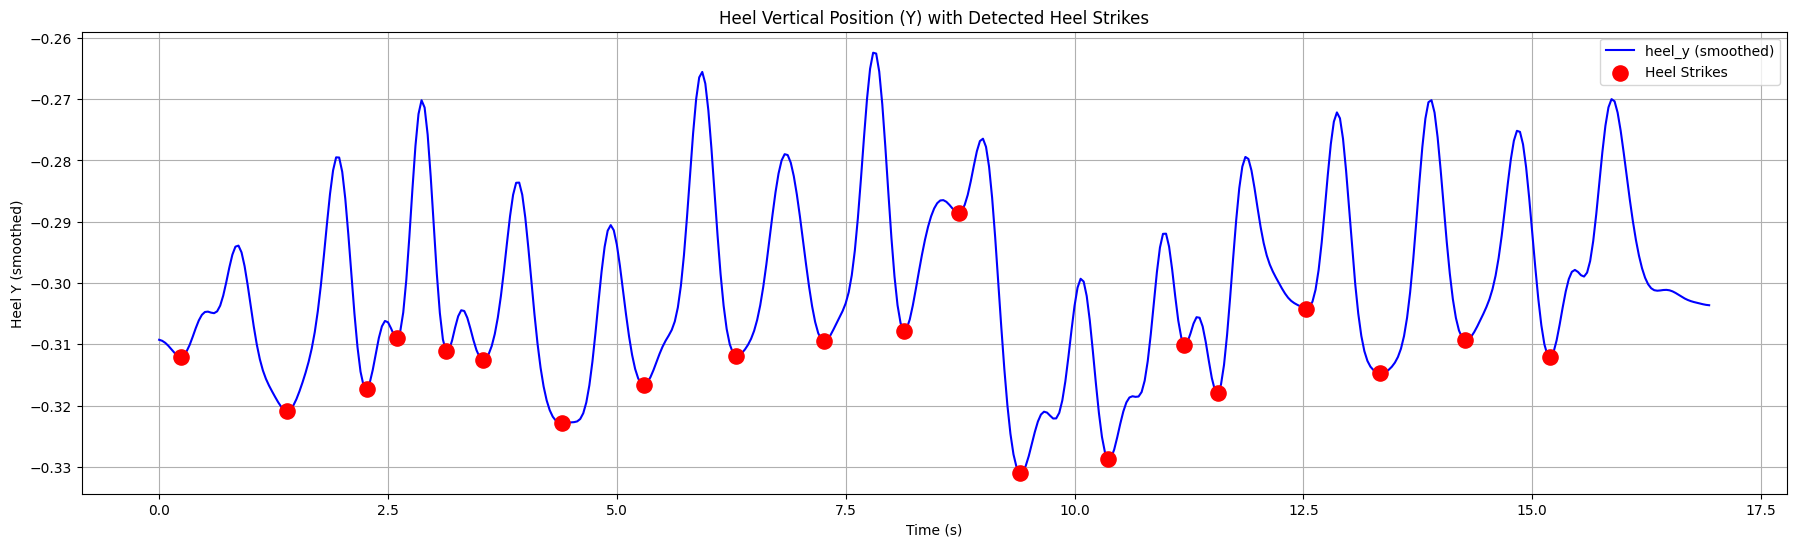

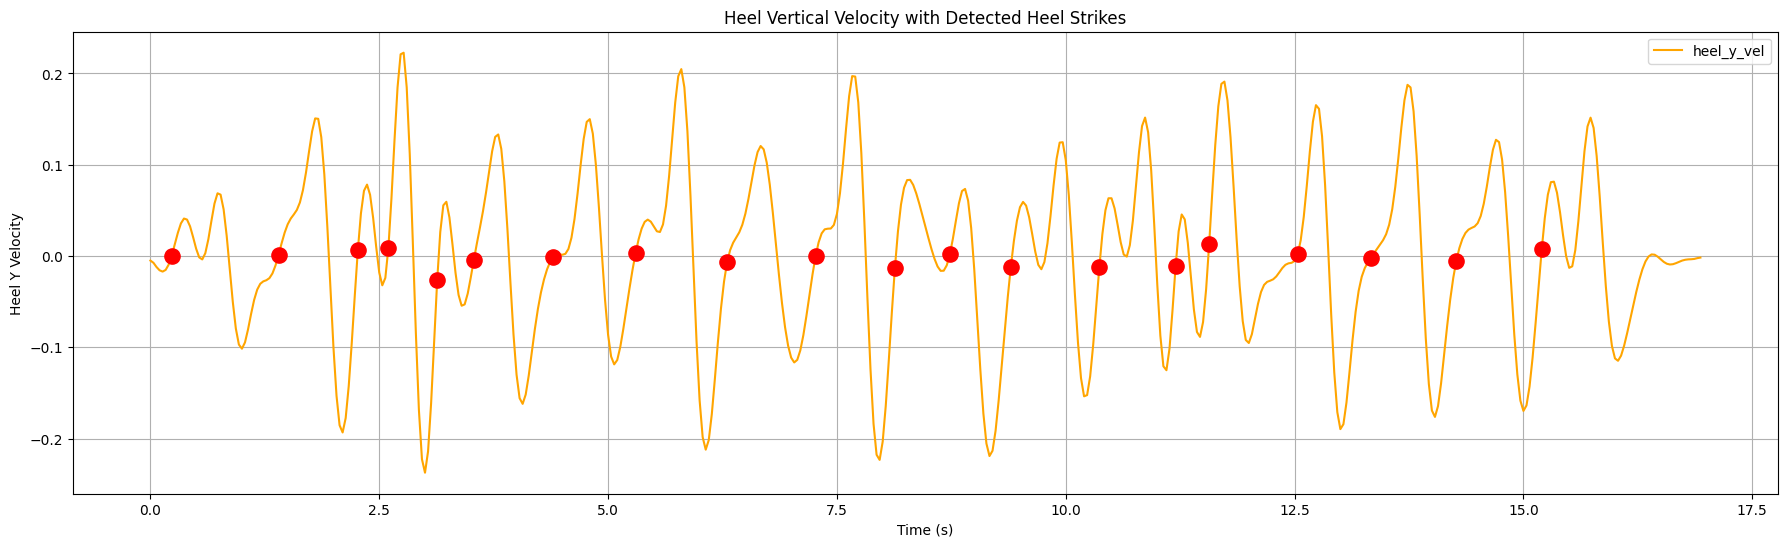

In [ ]:
# Plot heel_y_smoothed with strike markers
plt.figure(figsize=(22,6))
plt.plot(time, heel_y_smooth, label="heel_y (smoothed)", color='blue')

plt.scatter(time[heel_strikes], heel_y_smooth[heel_strikes],
            color='red', s=120, zorder=5, label="Heel Strikes")

plt.title("Heel Vertical Position (Y) with Detected Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Heel Y (smoothed)")
plt.grid(True); plt.legend(); plt.show()


# Plot velocity with heel strikes
heel_y_vel = np.gradient(heel_y_smooth, dt)

plt.figure(figsize=(22,6))
plt.plot(time, heel_y_vel, label="heel_y_vel", color='orange')

plt.scatter(time[heel_strikes], heel_y_vel[heel_strikes],
            color='red', s=120, zorder=5)

plt.title("Heel Vertical Velocity with Detected Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Heel Y Velocity")
plt.grid(True); plt.legend(); plt.show()


In [ ]:
# Estimate Center of Mass velocity & trunk yaw for clipping stand still and turning gait cycles
dt = 1.0 / fps
left_hip = points[:, 23, :]
right_hip = points[:, 24, :]
hip_center = (left_hip + right_hip) / 2.0

# Hip velocity magnitude
hip_vel = np.linalg.norm(np.diff(hip_center, axis=0), axis=1) / dt
hip_vel_smooth = gaussian_filter1d(hip_vel, sigma=4)

# Shoulder vector to estimate body yaw
left_shoulder = points[:, 11, :]
right_shoulder = points[:, 12, :]
shoulder_vec = right_shoulder - left_shoulder 

# Yaw angle: rotation around vertical axis using x-z plane
yaw = np.arctan2(shoulder_vec[:, 2], shoulder_vec[:, 0])
yaw_diff = np.diff(yaw)

yaw_diff = np.unwrap(yaw_diff)
yaw_vel = np.abs(yaw_diff) / dt

hip_vel_padded = np.concatenate([[hip_vel_smooth[0]], hip_vel_smooth])
yaw_vel_padded = np.concatenate([[yaw_vel[0]], yaw_vel])

# Thresholds for yaw and hip which invalid heel strikes
hip_vel_threshold = max(0.015, np.percentile(hip_vel_smooth, 5))
yaw_vel_threshold = np.deg2rad(60)

print(f"Using hip_vel_threshold: {hip_vel_threshold}")
print(f"Using yaw_vel_threshold (degs/s): {np.rad2deg(yaw_vel_threshold)}")

is_moving = hip_vel_padded > hip_vel_threshold
is_turning = yaw_vel_padded > yaw_vel_threshold

# Boolean mask to make subject is moving and not turning at a given frame
valid_gait_mask = is_moving & (~is_turning) 


Using hip_vel_threshold: 0.06271709422782173
Using yaw_vel_threshold (degs/s): 59.99999999999999


In [ ]:
filtered_heel_strikes = np.array([
    idx for idx in heel_strikes
    if 0 <= idx < len(valid_gait_mask) and valid_gait_mask[idx]
])

print(f"Detected filtered heel strikes: {len(filtered_heel_strikes)}")
print("Indices:", filtered_heel_strikes)

Detected filtered heel strikes: 17
Indices: [ 42  68  78  94 106 159 189 218 244 262 282 311 336 347 400 428 456]


In [ ]:
counter = 1
for heel_strike in heel_strikes:
  print(f"Heel Strike {counter}: {heel_strike} at {time[heel_strike]:.3f}s")
  counter = counter + 1

# Extract screenshots from video at each heel strike
print(f"\n{'='*60}")
print("Extracting video frames at heel strike timestamps...")
print(f"{'='*60}\n")

# Check if video file exists
if not os.path.exists(video_file):
    print(f"ERROR: Video file not found at {video_file}")
else:
    # Open the video
    cap = cv2.VideoCapture(video_file)
    
    if not cap.isOpened():
        print(f"ERROR: Could not open video file {video_file}")
    else:
        # Get video properties
        video_fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        print(f"Video properties:")
        print(f"  - FPS: {video_fps}")
        print(f"  - Total frames: {total_frames}")
        print(f"  - Resolution: {frame_width}x{frame_height}")
        print(f"  - Duration: {total_frames/video_fps:.2f}s\n")
        
        # Extract frames at each heel strike
        screenshots_saved = 0
        for i, hs in enumerate(filtered_heel_strikes):
            frame_idx = int(hs)
            timestamp = time[hs]
            
            # Set video position to the heel strike frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if not ret:
                print(f"  ERROR: Could not read frame {frame_idx}")
                continue

            # Save the full frame
            screenshot_path = (
                f"{screenshots_dir}/heel_strike_{i+1:02d}_"
                f"frame_{frame_idx:04d}_t_{timestamp:.3f}s.png"
            )
            cv2.imwrite(screenshot_path, frame)
            screenshots_saved += 1
            print(f"  Saved: heel_strike_{i+1:02d} (frame {frame_idx}, time {timestamp:.3f}s)")
        
        cap.release()
        print(f"\n{'='*60}")
        print(f"Successfully saved {screenshots_saved}/{len(heel_strikes)} heel strike screenshots")
        print(f"Screenshots saved to: {screenshots_dir}")
        print(f"{'='*60}")

Heel Strike 1: 7 at 0.233s
Heel Strike 2: 42 at 1.400s
Heel Strike 3: 68 at 2.267s
Heel Strike 4: 78 at 2.600s
Heel Strike 5: 94 at 3.133s
Heel Strike 6: 106 at 3.533s
Heel Strike 7: 132 at 4.400s
Heel Strike 8: 159 at 5.300s
Heel Strike 9: 189 at 6.300s
Heel Strike 10: 218 at 7.267s
Heel Strike 11: 244 at 8.133s
Heel Strike 12: 262 at 8.733s
Heel Strike 13: 282 at 9.400s
Heel Strike 14: 311 at 10.367s
Heel Strike 15: 336 at 11.200s
Heel Strike 16: 347 at 11.567s
Heel Strike 17: 376 at 12.533s
Heel Strike 18: 400 at 13.333s
Heel Strike 19: 428 at 14.267s
Heel Strike 20: 456 at 15.200s

Extracting video frames at heel strike timestamps...

Video properties:
  - FPS: 29.964
  - Total frames: 543
  - Resolution: 1920x1080
  - Duration: 18.12s

  Saved: heel_strike_01 (frame 42, time 1.400s)
  Saved: heel_strike_02 (frame 68, time 2.267s)
  Saved: heel_strike_03 (frame 78, time 2.600s)
  Saved: heel_strike_04 (frame 94, time 3.133s)
  Saved: heel_strike_05 (frame 106, time 3.533s)
  Saved:

In [ ]:
# # Compute velocity via 3d distance formula
# velocity = []
# for i in range(len(points) - 1):
#     if points[i] is None or points[i + 1] is None:
#         continue
#     p1 = points[i][landmark_index]
#     p2 = points[i + 1][landmark_index]
#     d = math.sqrt(
#         ((p2[0] - p1[0]) ** 2) +
#         ((p2[1] - p1[1]) ** 2) +
#         ((p2[2] - p1[2]) ** 2)
#     )
#     velocity.append(d)

# velocity = np.array(velocity)

# # Sanity Check
# assert len(velocity) == len(valid_gait_mask)

In [ ]:
# Compute velocity and acceleration 
# acceleration = np.gradient(velocity, dt)
# time = np.arange(len(velocity)) / fps

# velocity_smooth = gaussian_filter1d(velocity, sigma=6)
# acceleration_smooth = gaussian_filter1d(acceleration, sigma=6)

In [ ]:
# # Use percentile-based threshold for negative acceleration peaks
# # height = abs(np.percentile(acceleration_smooth, 15))
# # print(f"Using negative acceleration threshold: {height}")

# # Find peaks in NEGATIVE acceleration (moments of rapid deceleration/impact)
# # distance=15 ensures we don't detect multiple peaks within a single gait cycle (0.5s apart minimum)
# # heel_strikes, props = find_peaks(-acceleration_smooth, height=height, distance=15)

# # # Also find positive acceleration peaks for reference (push-off phase)
# # accel_peaks, _ = find_peaks(acceleration_smooth, height=height, distance=15)

# valid_heel_strikes = [hs for hs in heel_strikes if valid_gait_mask[hs]]
# valid_heel_strikes = np.array(valid_heel_strikes, dtype=int)

# print(f"Total heel strikes (raw): {len(heel_strikes)}")
# print(f"Total heel strikes (after filtering standstill/turns): {len(valid_heel_strikes)}")

# #Alert if number of heelstrikes too small
# if len(valid_heel_strikes) < 3:
#   print("Less than 3 heel strikes after filtering; Recheck both hip_vel_threshold and yaw_vel_threshold")


# # Plot acceleration with detected heel strikes
# plt.figure(figsize=(20, 8))
# plt.plot(time, acceleration_smooth, label='Acceleration', color='purple', linewidth=2)
# plt.scatter(time[heel_strikes], acceleration_smooth[heel_strikes],
#             color='gray', label='All Heel Strikes (raw)', s=50, alpha=0.4, zorder=4)
# plt.scatter(time[valid_heel_strikes], acceleration_smooth[valid_heel_strikes],
#             color='blue', label='Valid Heel Strikes (filtered)', s=120, zorder=5)
# plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=50))
# plt.xlim(left=0)
# plt.xlabel('Time (s)')
# plt.ylabel('Acceleration')
# plt.title(f'{landmark_name} Acceleration with Detected Heel Strikes (Filtered)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig(f'{outputdir}/{subject_number}-{view}-cycles-acceleration.png')
# plt.show()

# # Also plot velocity for comparison
# plt.figure(figsize=(20, 8))
# plt.plot(time, velocity_smooth, label='Velocity', color='green', linewidth=2)
# plt.scatter(time[valid_heel_strikes], velocity_smooth[valid_heel_strikes],
#             color='blue', label='Valid Heel Strikes', s=120, zorder=5)
# plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=50))
# plt.xlim(left=0)
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity')
# plt.title(f'{landmark_name} Velocity with Valid Heel Strikes')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig(f'{outputdir}/{subject_number}-{view}-cycles-velocity.png')
# plt.show()

In [ ]:
# if len(valid_heel_strikes) >= 3:
#     first_heel_strike = valid_heel_strikes[0]
#     third_heel_strike = valid_heel_strikes[2]
# else:
#     # fallback if not enough filtered strikes
#     first_heel_strike = heel_strikes[0]
#     third_heel_strike = heel_strikes[2]
#     print("Warning: Using raw heel_strikes for cropping due to insufficient valid strikes.")

# # Crop data
# crop_velocity = velocity_smooth[first_heel_strike : third_heel_strike + 1]
# crop_acceleration = acceleration_smooth[first_heel_strike : third_heel_strike + 1]
# crop_time = time[first_heel_strike : third_heel_strike + 1]

# crop_heel_strikes = [
#     hs - first_heel_strike
#     for hs in valid_heel_strikes
#     if (hs >= first_heel_strike and hs <= third_heel_strike)
# ]
# crop_accel_peaks = [
#     peak - first_heel_strike
#     for peak in accel_peaks
#     if (peak >= first_heel_strike and peak <= third_heel_strike)
# ]
# # Plot acceleration for the 2 gait cycles
# plt.figure(figsize=(20, 8))
# plt.plot(crop_time, crop_acceleration, label='Acceleration', color='purple', linewidth=2)
# plt.scatter(crop_time[crop_heel_strikes], crop_acceleration[crop_heel_strikes],
#             color='blue', label='Heel Strikes (Deceleration Peaks)', s=150, zorder=5)
# plt.scatter(crop_time[crop_accel_peaks], crop_acceleration[crop_accel_peaks],
#             color='red', label='Positive Accel Peaks', s=100, alpha=0.7)
# plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=50))
# plt.xlabel('Time (s)')
# plt.ylabel('Acceleration')
# plt.title(f'{landmark_name} Acceleration - 2 Gait Cycles (Filtered)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig(f'{outputdir}/{subject_number}-{view}-cycles-trimmed-acceleration.png')
# plt.show()

# # Plot velocity for comparison
# plt.figure(figsize=(20, 8))
# plt.plot(crop_time, crop_velocity, label='Velocity', color='green', linewidth=2)
# plt.scatter(crop_time[crop_heel_strikes], crop_velocity[crop_heel_strikes],
#             color='blue', label='Heel Strikes', s=150, zorder=5)
# plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=50))
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity')
# plt.title(f'{landmark_name} Velocity - 2 Gait Cycles (Filtered)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig(f'{outputdir}/{subject_number}-{view}-cycles-trimmed-velocity.png')
# plt.show()

In [ ]:
# # Export cropped 2 gait cycles back to mediapipe landmarks
# with open(input_file, "r") as f:
#     new_data = json.load(f)

# new_data['landmarks_data'] = new_data['landmarks_data'][first_heel_strike - 1 : third_heel_strike]
# with open(output_file, 'w') as f:
#     json.dump(new_data, f, indent=4)

# print(f'Wrote 2 gait cycles clipped to {output_file}')